# **Fraudulent Risk Prediction: Machine Learning Assisting Audit Planning**

Shuang Zhang

## **0. Introduction**

Over the past few decades, there have been a number of major corporate failures as a result of fraud. These failures reinforce the need for fraud detection. Along with other members of the corporate governance and reporting ecosystem, auditors play an important role in detecting material fraud.

External audit is the process of an independent third party (the audit firm) examining the financial records of a business to provide reasonable assurance to shareholders that the financial statements of that company, taken as a whole, are free from material misstatement. 

Companies have never been as data-rich as they are today, potentially providing entirely new opportunities to detect material frauds through data analysis and interpretation. Auditors are already increasingly using data analytics to identify unusual transactions and patterns of transactions
that might indicate a material fraud. Nevertheless, an important human element still comes into play. Auditors need to focus more on corporate culture and behaviors to support fraud detection, which require auditors to use professional judgement based on knowledge and experience. 

The first step in an auditing process is the audit-planning phase, whose primary goal is to identify risks that may lead to material misstatement, including risk of fraud, and develop preliminary audit strategies according to the risk level. Machine learning could be a powerful tool to provide actionable insight in audit planning. Identifying fraudulent companies can be framed as a classification problem. The companies with high fraud risk warrant significant investigation and exentive field work.

In this analysis, our data comes from Comptroller and Auditor General (CAG) of India, which is an independent constitutional body responsible for auditing all government-funded companies. The dataset is consisted of present and historical risk factors of 777 companies from 14 different sectors. The two main objectives of this analysis are as follows:

- To examine the relationship between risk factors and fraud risk score obtained from analytical procedure (Regression)
- To test the performance of 5 machine learning models in the prediction of fraud risk class (Classification)

Stakeholders involved:
- Auditor: determine the nature, timing and extent of the audit work
- The users of the audit report: Current shareholders, future shareholders, bankers, creditors, management of company, employee, government, wider public, etc.

## **1. Collecting Data**

Data is collected from Kaggle website using KaggleApi.

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
from zipfile import ZipFile

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Connect to Kaggle:

In [3]:
api = KaggleApi()
api.authenticate()

Search for the desired dataset:

In [4]:
datasets_ls = api.datasets_list(search='audit')
[item['url'] for item in datasets_ls]

['https://www.kaggle.com/datasets/sid321axn/audit-data',
 'https://www.kaggle.com/datasets/tusharaggarwal27/audit-risk-data',
 'https://www.kaggle.com/datasets/mpwolke/cusersmarildownloadsanxietycsv',
 'https://www.kaggle.com/datasets/vipulshinde/incident-response-log',
 'https://www.kaggle.com/datasets/atombalan/electrical-energy-audit-data',
 'https://www.kaggle.com/datasets/thedevastator/a-large-scale-analysis-of-google-search',
 'https://www.kaggle.com/datasets/danishashah/audit-risks',
 'https://www.kaggle.com/datasets/aellatif/audit-risk',
 'https://www.kaggle.com/datasets/okfn/open-data',
 'https://www.kaggle.com/datasets/apachaves/brazil-parliamentary-quota',
 'https://www.kaggle.com/datasets/jeffheaton/are-two-sentences-of-the-same-topic',
 'https://www.kaggle.com/datasets/richardnewton/qualitystreet',
 'https://www.kaggle.com/datasets/jazzang/opioid-overdose-deaths',
 'https://www.kaggle.com/datasets/brendankelley/hive-annotation-job-results-cleaned-and-audited',
 'https://ww

Download the dataset:

In [5]:
api.dataset_download_files('sid321axn/audit-data')

In [6]:
[file for file in os.listdir(os.curdir) if (file.endswith('.zip') | file.endswith('.csv'))]

['audit-data.zip']

Unzip the file:

In [7]:
zf = ZipFile('audit-data.zip')
zf.extractall() 
zf.close()

In [8]:
[file for file in os.listdir(os.curdir) if file.endswith('.csv')]

['audit_data.csv', 'trial.csv']

Load the dataset into a pandas dataframe:

In [9]:
audit = pd.read_csv('trial.csv')

In [10]:
audit.head()

,Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
0,3.89,23,4.18,6,2.50,2,6.68,5.0,2,3.38,2,2,0,2,0,2,2.4,1
1,3.89,6,0.00,2,4.83,2,4.83,5.0,2,0.94,2,2,0,2,0,2,2.0,0
2,3.89,6,0.51,2,0.23,2,0.74,5.0,2,0.00,2,2,0,2,0,2,2.0,0
3,3.89,6,0.00,2,10.80,6,10.80,6.0,6,11.75,6,2,0,2,0,2,4.4,1
4,3.89,6,0.00,2,0.08,2,0.08,5.0,2,0.00,2,2,0,2,0,2,2.0,0


In [11]:
audit.shape

(776, 18)

In [12]:
for file in ['audit-data.zip', 'audit_data.csv', 'trial.csv']:
    os.remove(file) 

## **2. Data Cleaning and Exploratory Data Analysis**

The data set has 18 columns. The first 16 columns represent auditors' findings. <br>
The second last column "**Score**" is the total risk score obtained from analytical procedure (ARS score), and the last column "**Risk**" is the risk class: 1 means "fraud" and 0 means "no-fraud".  

In [13]:
pd.crosstab(audit.Risk, audit.Score) 

Score,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,5.0,5.2
Risk,,,,,,,,,,,,,,,,,
0,290,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,97,79,51,20,19,26,19,30,27,36,30,24,9,13,2,4


From this crosstab, we can see that companies with an ARS score higher than 2.0 are classified as 'Fraud'.

The risk factors we are interested in are listed below:

| Risk Factor | Description |
| --- | --- |
| **Para A Value** | Discrepancy found in the planned-expenditure of inspection and summary report A in Rs (in crore) | 
| **Para B Value** | Discrepancy found in the unplanned-expenditure of inspection and summary report B in Rs (in crore) | 
| **Total** | Total amount of discrepancy found in other reports Rs (in crore) | 
| **Numbers** | Historical discrepancy score | 
| **Money Value** | Amount of money involved in misstatements in the past audits | 
| **Sector score** | Historical risk score value of the sector to which the company belongs | 
| **Loss** | Amount of loss the company suffered last year |
| **History** | Average historical loss the company suffered in the last 10 years |
| **District score** | Historical risk score of the district where the company is located |

Remove unrelated columns:

In [14]:
audit = audit.drop(['LOCATION_ID', 'SCORE_A', 'SCORE_B', 'Marks', 'MONEY_Marks', 'Loss','History'], axis=1)

In [15]:
audit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sector_score   776 non-null    float64
 1   PARA_A         776 non-null    float64
 2   PARA_B         776 non-null    float64
 3   TOTAL          776 non-null    float64
 4   numbers        776 non-null    float64
 5   Money_Value    775 non-null    float64
 6   District       776 non-null    int64  
 7   LOSS_SCORE     776 non-null    int64  
 8   History_score  776 non-null    int64  
 9   Score          776 non-null    float64
 10  Risk           776 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 66.8 KB


The 'Money_Value' column has a missing value:

In [16]:
audit[audit.Money_Value.isnull()]

,Sector_score,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District,LOSS_SCORE,History_score,Score,Risk
642,55.57,0.23,0.0,0.23,5.0,NaN,2,2,2,2.0,0


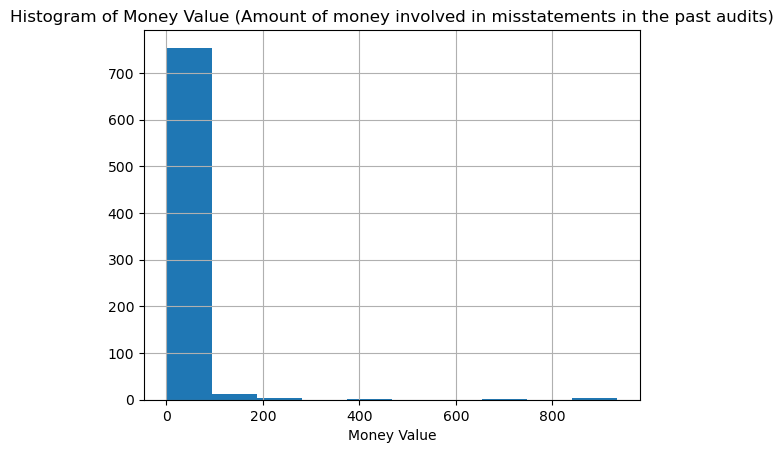

In [17]:
# A histogram of the Money_Value column:
audit.Money_Value.hist()
plt.xlabel('Money Value')
plt.title('Histogram of Money Value (Amount of money involved in misstatements in the past audits)');

From this histogram we can see that most companies did not involve in misstatements in the past audits.

Fill the missing value by 0:

In [18]:
audit['Money_Value'].fillna(0, inplace=True)

Check the descriptive statistics:

In [19]:
audit.describe()

,Sector_score,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District,LOSS_SCORE,History_score,Score,Risk
count,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000
mean,20.184536,2.450194,10.799988,13.218481,5.067655,14.119412,2.505155,2.061856,2.167526,2.702577,0.626289
std,24.319017,5.678870,50.083624,51.312829,0.264449,66.565468,1.228678,0.375080,0.679869,0.858923,0.484100
min,1.850000,0.000000,0.000000,0.000000,5.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000
25%,2.370000,0.210000,0.000000,0.537500,5.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000
50%,3.890000,0.875000,0.405000,1.370000,5.000000,0.090000,2.000000,2.000000,2.000000,2.400000,1.000000
75%,55.570000,2.480000,4.160000,7.707500,5.000000,5.587500,2.000000,2.000000,2.000000,3.250000,1.000000
max,59.850000,85.000000,1264.630000,1268.910000,9.000000,935.030000,6.000000,6.000000,6.000000,5.200000,1.000000


The columns 'PARA_B' and 'TOTAL' both have extremely large maximum values. Check how many records have abnormal values:

In [20]:
audit[(audit.PARA_B>1000) | (audit.TOTAL>1000)]

,Sector_score,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District,LOSS_SCORE,History_score,Score,Risk
241,2.72,4.28,1264.63,1268.91,5.5,58.86,6,2,6,5.2,1


There is only one record has 'PARA_B' and "TOTAL' values larger than 1000, remove this record since it is likely to be a transcription error:

In [21]:
audit = audit.drop(audit[audit.PARA_B>1000].index)

In [22]:
audit.describe()

,Sector_score,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District,LOSS_SCORE,History_score,Score,Risk
count,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000
mean,20.207071,2.447833,9.182143,11.598234,5.067097,14.061683,2.500645,2.061935,2.162581,2.699355,0.625806
std,24.326613,5.682157,21.860139,24.425816,0.264162,66.589014,1.223029,0.375316,0.666196,0.854771,0.484226
min,1.850000,0.000000,0.000000,0.000000,5.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000
25%,2.370000,0.210000,0.000000,0.535000,5.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000
50%,3.890000,0.870000,0.400000,1.370000,5.000000,0.090000,2.000000,2.000000,2.000000,2.400000,1.000000
75%,55.570000,2.470000,4.070000,7.660000,5.000000,5.535000,2.000000,2.000000,2.000000,3.200000,1.000000
max,59.850000,85.000000,144.390000,191.360000,9.000000,935.030000,6.000000,6.000000,6.000000,5.200000,1.000000


Check the distribution of the risk factors using box plots:

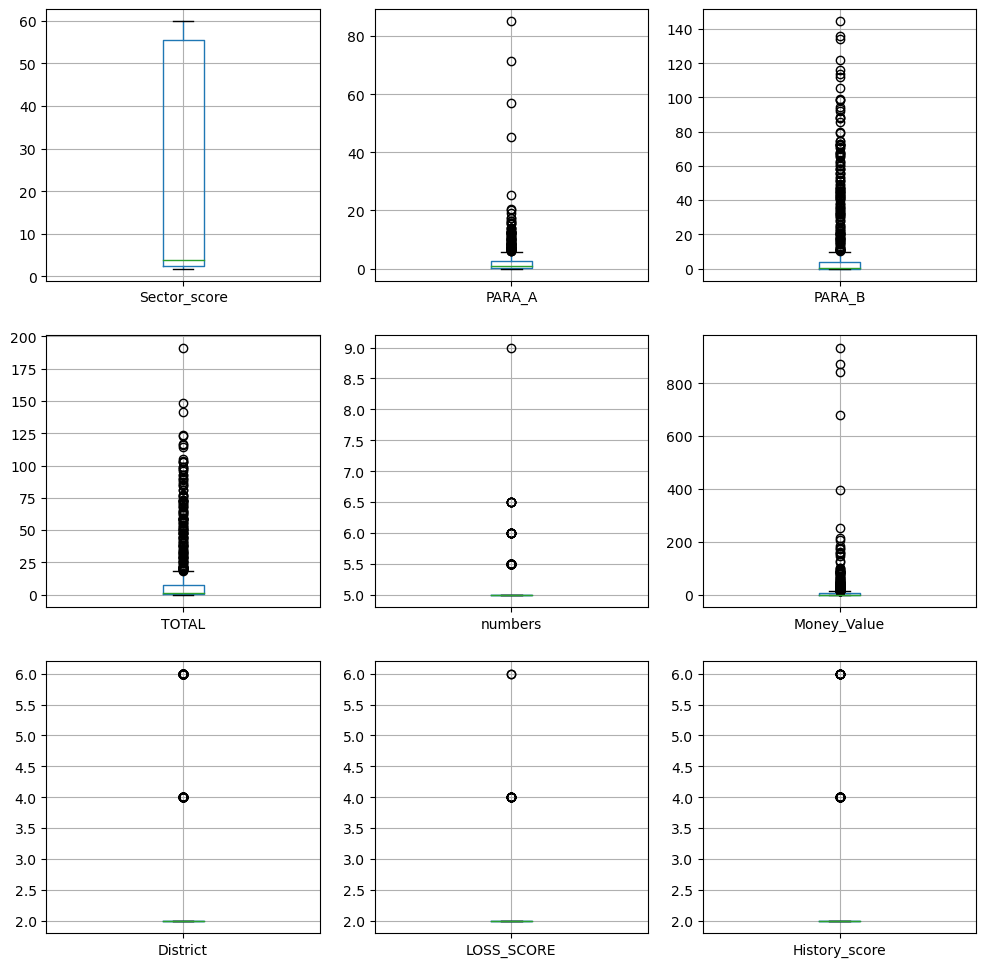

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))

for column, ax in zip((audit.iloc[:,:-1]).columns, axs.ravel()):
    (audit.iloc[:,:-1])[[column]].boxplot(ax=ax);
    
plt.savefig('boxplot.png')

Check the correlation between variables:

In [24]:
audit.corr()

,Sector_score,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District,LOSS_SCORE,History_score,Score,Risk
Sector_score,1.000000,-0.216611,-0.250987,-0.274652,-0.150633,-0.117273,-0.106154,-0.086934,-0.134504,-0.336583,-0.374140
PARA_A,-0.216611,1.000000,0.347391,0.539976,0.133345,0.449249,0.127295,0.043780,0.173907,0.427820,0.292236
PARA_B,-0.250987,0.347391,1.000000,0.976320,0.360501,0.236994,-0.020873,0.109781,0.314208,0.698726,0.316126
TOTAL,-0.274652,0.539976,0.976320,1.000000,0.349454,0.310103,0.007209,0.108649,0.318070,0.722669,0.349898
numbers,-0.150633,0.133345,0.360501,0.349454,1.000000,0.185199,0.119836,0.036219,0.202228,0.500285,0.196535
Money_Value,-0.117273,0.449249,0.236994,0.310103,0.185199,1.000000,0.026014,0.031978,0.109655,0.291053,0.160331
District,-0.106154,0.127295,-0.020873,0.007209,0.119836,0.026014,1.000000,0.056206,0.064885,0.202003,0.316739
LOSS_SCORE,-0.086934,0.043780,0.109781,0.108649,0.036219,0.031978,0.056206,1.000000,0.145697,0.169271,0.127688
History_score,-0.134504,0.173907,0.314208,0.318070,0.202228,0.109655,0.064885,0.145697,1.000000,0.433536,0.188832
Score,-0.336583,0.427820,0.698726,0.722669,0.500285,0.291053,0.202003,0.169271,0.433536,1.000000,0.633077


The correlation coefficient between 'PARA_B' and 'TOTAL' is close to 1.Check the difference between 'TOTAL' and 'PARA_B':

In [25]:
(audit['TOTAL']-audit['PARA_B']).describe()

count    775.000000
mean       2.416091
std        5.645388
min        0.000000
25%        0.200000
50%        0.850000
75%        2.455000
max       85.000000
dtype: float64

'TOTAL' is always larger than 'PARA_B' (the minimum difference is 0), and in most cases the difference between these two values are fairly small. Check if 'TOTAL' is the sum of 'PARA_A' and 'PARA_B':

In [26]:
diff = audit['TOTAL']-audit['PARA_B']-audit['PARA_A']
diff.describe()

count    7.750000e+02
mean    -3.174194e-02
std      7.550383e-01
min     -2.065000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.199041e-14
dtype: float64

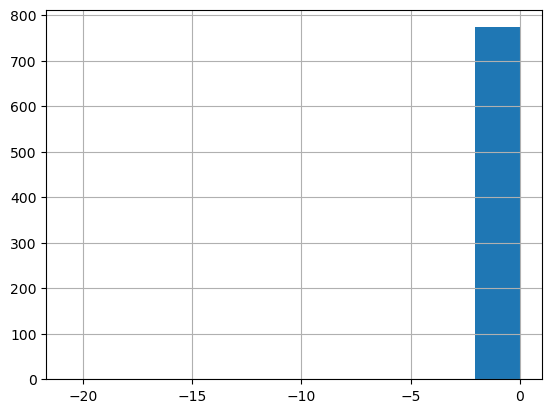

In [27]:
diff.hist();

In [28]:
# Count how may records have virtually the same value of 'TOTAL' and 'PARA_A' plus 'PARA_B'
(diff.abs() < 0.01).value_counts()

True     773
False      2
dtype: int64

The above histogram and value counts show that in 773 out of 775 records, 'TOTAL' is the sum of 'PARA_A' and 'PARA_B'. Hence, we drop the 'TOTAL' column.

In [29]:
audit.drop(['TOTAL'], axis=1, inplace = True)

Rename and rearrange the columns:

In [30]:
col_names = ['sector','para_a','para_b','numbers','money','district','loss','history','ars','risk']
audit.columns = col_names
audit = audit[['para_a','para_b','numbers','money','sector','district','loss','history','ars','risk']]

A glimpse of pairwise bivariate distributions of all variables:

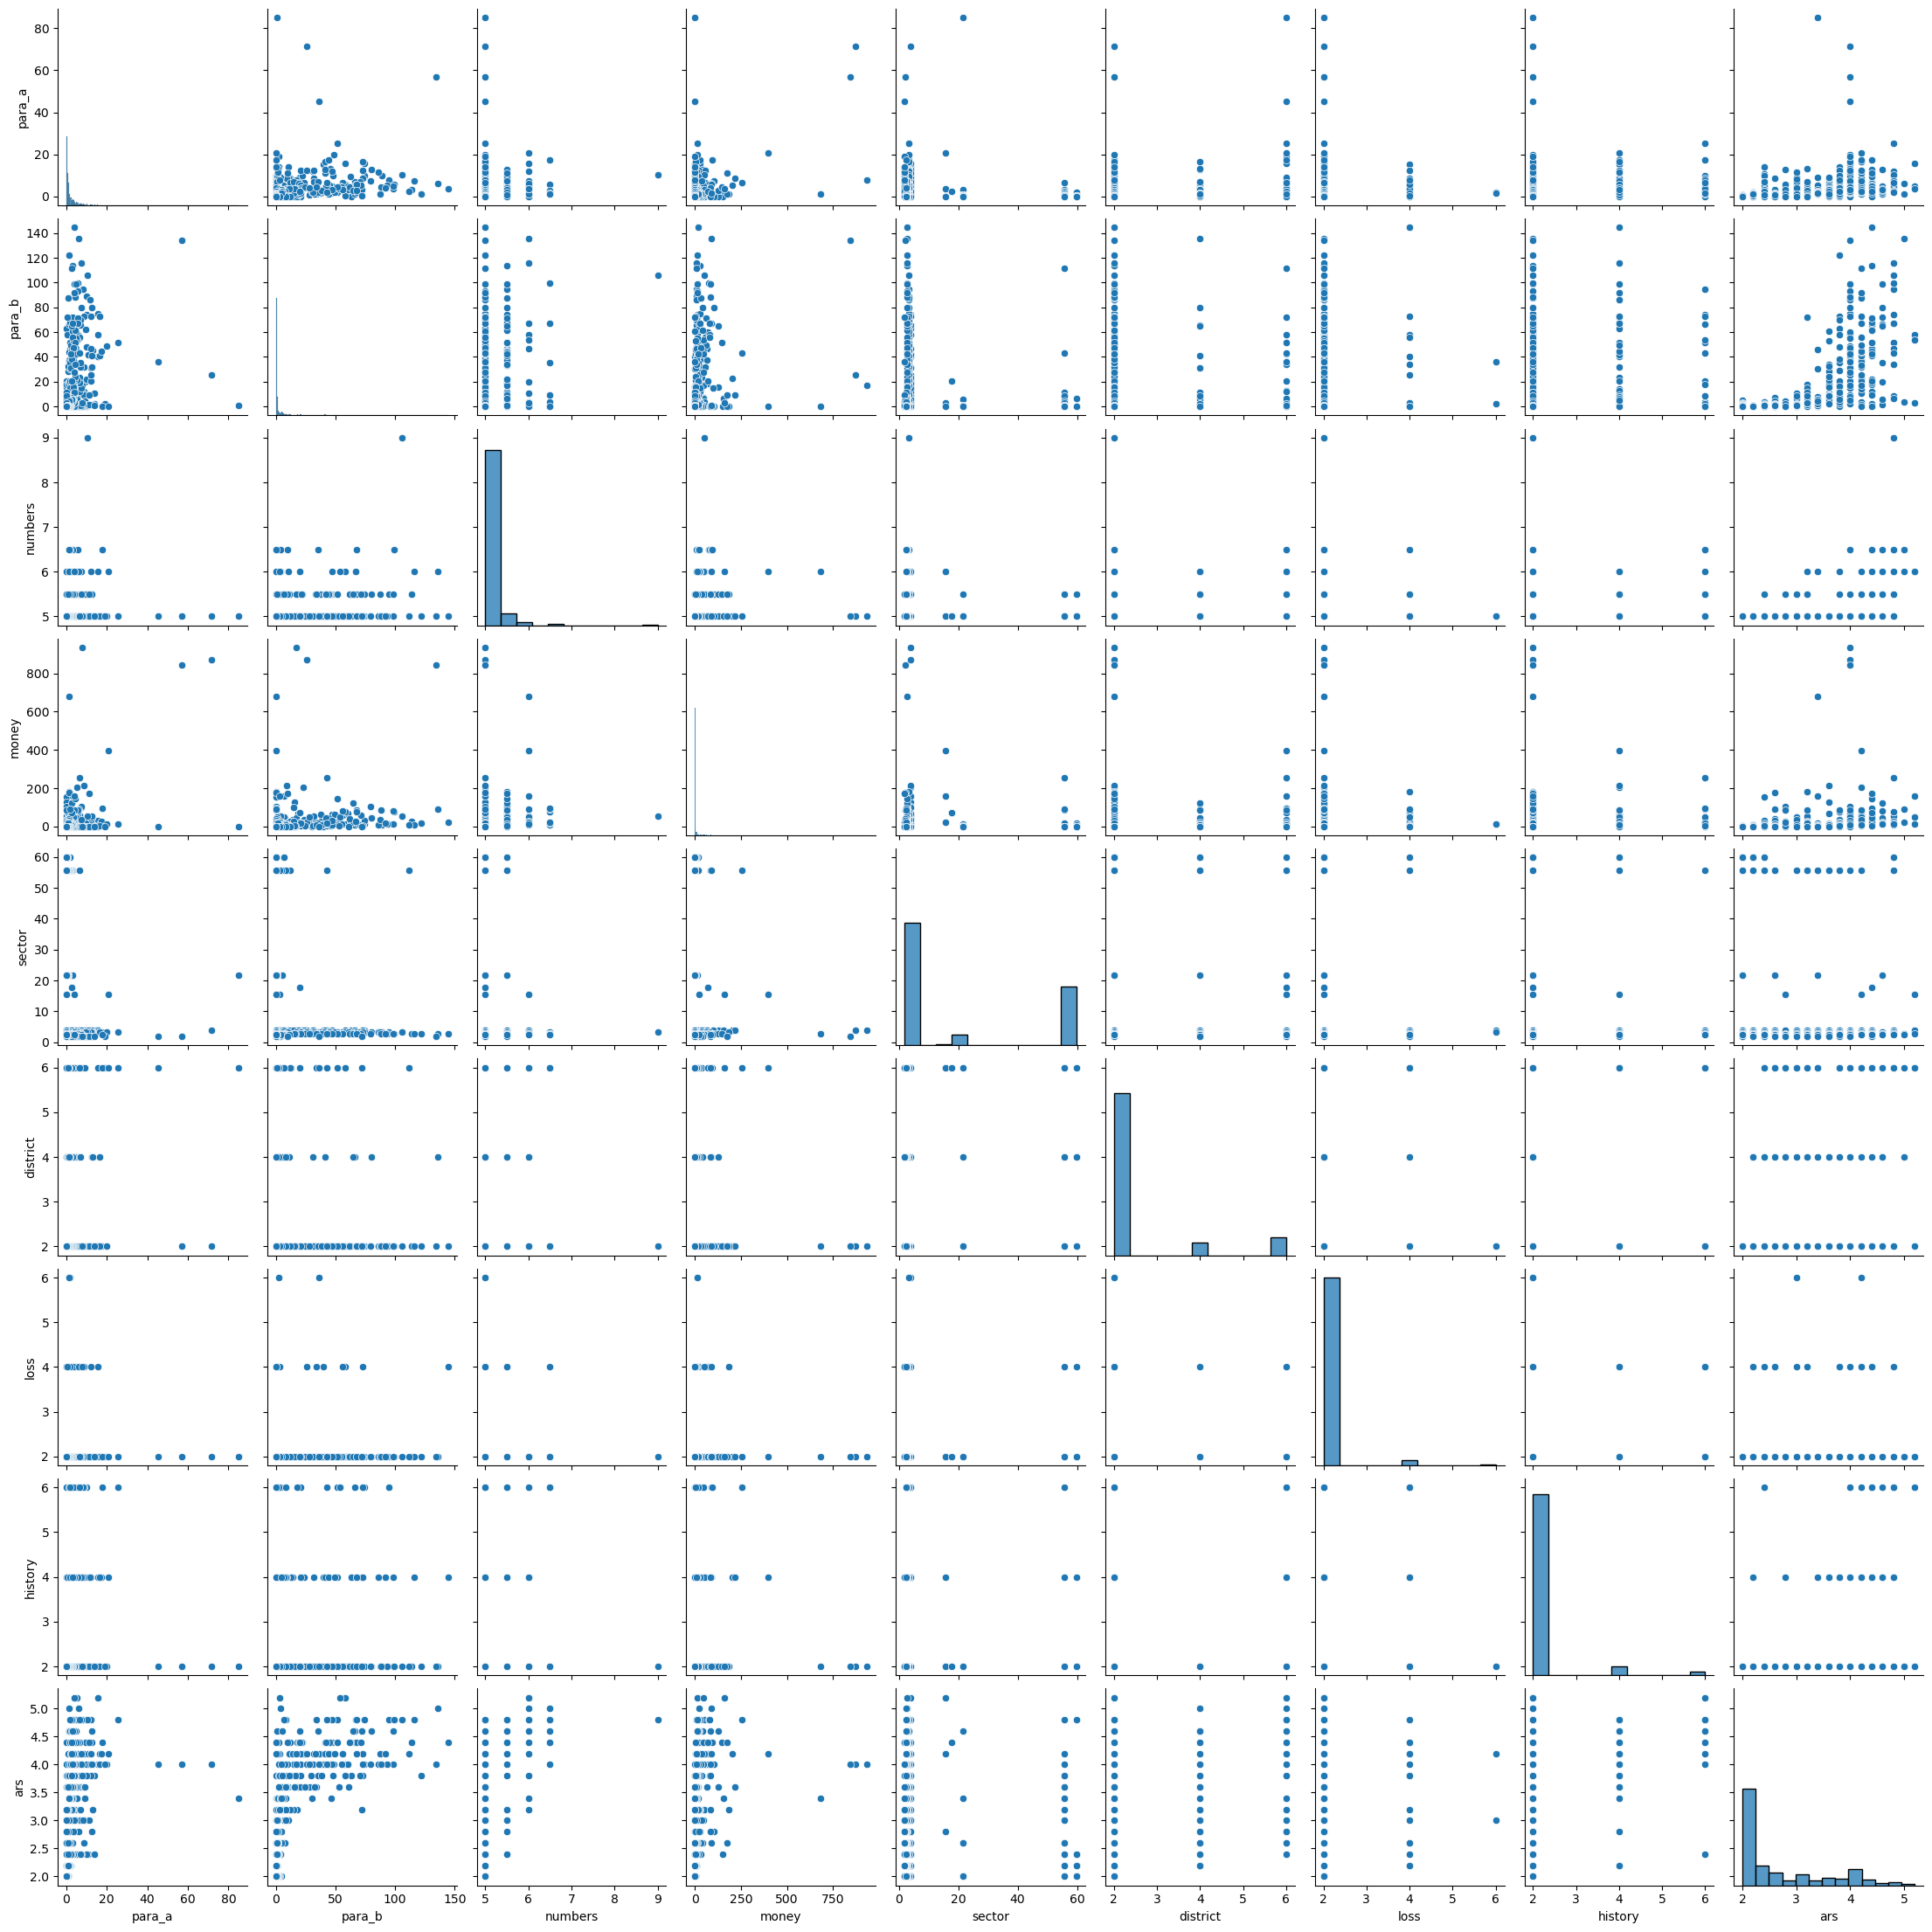

In [31]:
sns.pairplot(audit.iloc[:,:-1]);

## **3. Regression**

### 3.0. Feature Engineering

Apply logarithm transformation on 'para_a', 'para_b' and 'money' as they are highly right-skewed, and divide 'sector' by 10 for regularisation purpose as it is approximately 10 times higher than other scores ('district', 'history' and 'loss').

In [32]:
audit_log = audit.copy()
audit_log[['para_a', 'para_b', 'money']] = audit_log[['para_a', 'para_b', 'money']].apply(lambda x:np.log(x+1))
audit_log['sector'] = audit_log['sector']/10

### 3.1. Linear Regression

Import packages:

In [33]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LearningCurveDisplay, ShuffleSplit

Define the predictor matrix and the target variable:

In [34]:
X = audit_log.iloc[:,:-2]
y = audit_log['ars']

Train-test split:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

Create a linear regression model and fit it with the training data:

In [36]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

Calculate the R-squared and root mean squrared error (RMSE) for the test data:

In [37]:
r2 = linreg.score(X_test, y_test)
rmse = metrics.mean_squared_error(y_test, linreg.predict(X_test), squared = False)
print(f'R-squared: {r2:.04f}' + '\n' + f'Root mean squrared error (RMSE): {rmse:.04f}')

R-squared: 0.8856
Root mean squrared error (RMSE): 0.2736


Indicating that 88.56% of the variation in y is explained by the change in X.

5-Fold cross validation:

In [38]:
k_fold = KFold(5, shuffle=True, random_state=42)

In [39]:
# Crosscheck using cross_val_score
cv_scores = cross_val_score(LinearRegression(), X, y, cv=k_fold)
cv_rmses = np.sqrt(-(cross_val_score(LinearRegression(), X, y, scoring = 'neg_mean_squared_error', cv=k_fold)))
cv_df = pd.DataFrame({'R2': cv_scores, 'RMSE': cv_rmses})

In [40]:
cv_df.round(4)

,R2,RMSE
0,0.9249,0.2211
1,0.8915,0.2619
2,0.8988,0.2910
3,0.8605,0.3258
4,0.9082,0.2606


Learning curve of linear regression:

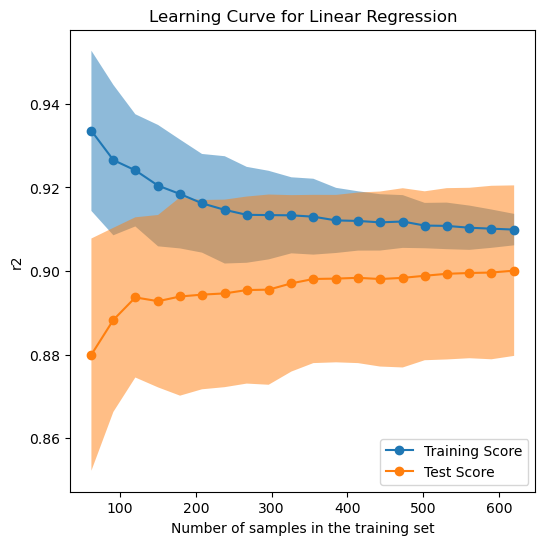

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))

params = {
    'X': X,
    'y': y,
    'train_sizes': np.linspace(0.1, 1.0, 20),
    'cv': ShuffleSplit(n_splits=50, test_size=0.2, random_state=42),
    'score_type': 'both',
    'n_jobs': -1,
    'line_kw': {'marker': 'o'},
    'std_display_style': 'fill_between',
    'score_name': 'r2',
}
    
LearningCurveDisplay.from_estimator(linreg, **params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ['Training Score', 'Test Score'], loc='lower right')
ax.set_title('Learning Curve for Linear Regression')
plt.savefig('lc_lr.png')

Both cross validation and learning curve suggest the bias and variance of this model are both fairly small: The R-squared is high and not sensitive to the fluctuation of the training data.

### 3.2. Forward Feature Selection

Use forward feature selection to select best features:

In [42]:
# start with no predictors
included = []
# keep track of model and parameters
best = {'feature': '', 'r2': 0, 'a_r2': 0}

# get the number of cases in the training data
n = X_train.shape[0]

while True:
    changed = False
    
    # list the features to be evaluated
    excluded = list(set(X.columns) - set(included))
    
    # for each remaining feature to be evaluated
    for new_column in excluded:
        
      # fit the model with the Training data
        fit = linreg.fit(X_train[included + [new_column]], y_train)
        # calculate the score (R^2 for Regression)
        r2 = fit.score(X_train[included + [new_column]], y_train)
        # number of predictors in this model
        k = len(included + [new_column])
        # calculate the adjusted R^2
        adjusted_r2 = 1 - (((1 - r2) * (n - 1)) / (n - k - 1))

       # if model improves
        if adjusted_r2 > best['a_r2']:
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r2}
            # flag that found a better model
            changed = True      
    # END for

    # if found a better model after testing all remaining features
    if changed:
        # update control details
        included.append(best['feature'])
        excluded = list(set(excluded) - set(best['feature']))
        print('Added feature %-4s with R^2 = %.3f and adjusted R^2 = %.3f' % 
              (best['feature'], best['r2'], best['a_r2']))
    else:
        # terminate if no better model
        print('*'*50)
        break

print('')
print('Resulting features:')
print(', '.join(included))

Added feature para_b with R^2 = 0.759 and adjusted R^2 = 0.758
Added feature numbers with R^2 = 0.825 and adjusted R^2 = 0.824
Added feature para_a with R^2 = 0.865 and adjusted R^2 = 0.864
Added feature district with R^2 = 0.888 and adjusted R^2 = 0.888
Added feature money with R^2 = 0.903 and adjusted R^2 = 0.902
Added feature history with R^2 = 0.910 and adjusted R^2 = 0.909
Added feature loss with R^2 = 0.912 and adjusted R^2 = 0.911
Added feature sector with R^2 = 0.913 and adjusted R^2 = 0.912
**************************************************

Resulting features:
para_b, numbers, para_a, district, money, history, loss, sector


Display the order of features:

In [43]:
forward_coefs = pd.DataFrame({'feature': X.columns,
                         'coefficient': linreg.coef_,
                         'abs_coef': np.abs(linreg.coef_)})
forward_coefs.sort_values('abs_coef', inplace=True, ascending=False)
forward_coefs.drop(['abs_coef'], axis = 1, inplace = True)

The resulting order of feature importance:

In [44]:
forward_coefs.round(4)

,feature,coefficient
1,para_b,0.6736
0,para_a,0.3477
2,numbers,0.2001
6,loss,0.1205
5,district,0.1163
3,money,0.1115
4,sector,0.1018
7,history,0.0127


### 3.3 Lasso Regularisation

Find an optimal value for Lasso regression alpha using LassoCV:

In [45]:
lasso_alphas = np.logspace(-6, 6, 200) 

opt_lasso = LassoCV(alphas = lasso_alphas, cv=5)
opt_lasso.fit(X, y)

print(f'Alpha: {opt_lasso.alpha_:.04f}' + '\n' + f'Score: {opt_lasso.score(X, y):.04f}')

Alpha: 0.0095
Score: 0.9061


Visualise coefficients:

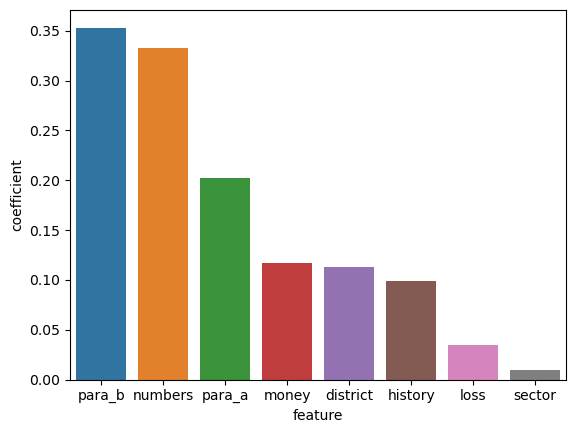

In [46]:
lasso_coefs = pd.DataFrame({'feature': X.columns,
                            'coefficient': opt_lasso.coef_,
                            'abs_coef': np.abs(opt_lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.drop(['abs_coef'], axis = 1, inplace = True)

sns.barplot(lasso_coefs, x='feature', y='coefficient');

The resulting order of feature importance:

In [47]:
lasso_coefs.round(4)

,feature,coefficient
1,para_b,0.3531
2,numbers,0.3329
0,para_a,0.2026
3,money,0.1173
5,district,0.1131
7,history,0.0990
6,loss,0.0347
4,sector,0.0093


## 4. Classification

Five classification models are employed to identify a company is fraudulent or not:
- **Logistic Regression (LR)**: computing the probability of a discrete outcome given an input variable
- **Support Vector machine classifier (SVC)**: mapping data to a high-dimensional feature space and looking for a hyperplane that separates the categories 
- **Naive Bayesian (NB)**: computing the conditional a posterior probabilities of a class variable of a given independent predictor variable
- **k Nearest Neighbor (KNN)**: classifing objects based on their proximate neighbors’ classes
- **Decision Trees (DT)**: classifying samples by sorting them down the tree

### 4.0 Grid Search for Optimal Hyperparameters

Import packages:

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import tree

Define the predictor matrix and the target variable:

In [49]:
X = audit.iloc[:,:-2]
y = audit['risk']

Train-test split:

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Standardise the predictor matrix using StandardScaler:

In [51]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Function to print the grid search results:

In [52]:
def best_results(mdl):
    print("The parameter setting that gave the best results is:", mdl.best_params_)
    print("The mean cross-validated score of the best_estimator is:", mdl.best_score_)

#### 4.0.1 Logistic regression (LR) grid search

In [53]:
lr_params = {
    'clf__C': [1, 10, 100]
}

In [54]:
lr = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter = 2000, random_state = 42))])
GS_lr = GridSearchCV(lr, lr_params, cv=3, n_jobs=-1)
GS_lr.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=2000,
                                                           random_state=42))]),
             n_jobs=-1, param_grid={'clf__C': [1, 10, 100]})

In [55]:
best_results(GS_lr)

The parameter setting that gave the best results is: {'clf__C': 100}
The mean cross-validated score of the best_estimator is: 0.873464826953199


Fit LR model with optimal hyperparameters:

In [56]:
lr = LogisticRegression(C=100, max_iter = 2000, random_state = 42)
lr.fit(X_train_s, y_train)

LogisticRegression(C=100, max_iter=2000, random_state=42)

#### 4.0.2 Support vector machine classifier (SVC) grid search

In [57]:
svc_params = {
    'clf__C': [1, 10, 100],
    'clf__gamma': [0.001, 0.0001],
    'clf__kernel': ['linear','rbf']
}

In [58]:
svc = Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability = True, random_state=42))])
GS_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
GS_svc.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [1, 10, 100], 'clf__gamma': [0.001, 0.0001],
                         'clf__kernel': ['linear', 'rbf']})

In [59]:
best_results(GS_svc)

The parameter setting that gave the best results is: {'clf__C': 100, 'clf__gamma': 0.001, 'clf__kernel': 'linear'}
The mean cross-validated score of the best_estimator is: 0.9018636576776111


Fit SVC model with optimal hyperparameters:

In [60]:
svc = SVC(kernel='linear', C=100, probability = True, random_state=42)
svc.fit(X_train_s, y_train)

SVC(C=100, kernel='linear', probability=True, random_state=42)

#### 4.0.3 Naive bayes (NB) grid search

In [61]:
nb_params = {
    'clf__var_smoothing': np.logspace(0,-9, num=100)
}

In [62]:
nb = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
GS_nb = GridSearchCV(nb, nb_params, cv=3, n_jobs=-1)
GS_nb.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', GaussianNB())]),
             n_jobs=-1,
             param_grid={'clf__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [63]:
best_results(GS_nb)

The parameter setting that gave the best results is: {'clf__var_smoothing': 6.579332246575683e-05}
The mean cross-validated score of the best_estimator is: 0.8269382339149781


Fit NB model with optimal hyperparameters:

In [64]:
nb = GaussianNB(var_smoothing = 6.5793e-05)
nb.fit(X_train_s, y_train)

GaussianNB(var_smoothing=6.5793e-05)

#### 4.0.4 K nearest neighbor (KNN) grid search

In [65]:
knn_params = {
    'clf__n_neighbors': np.arange(1,11)
}

In [66]:
knn = Pipeline([('scaler',StandardScaler()), ('clf',  KNeighborsClassifier())])
GS_knn = GridSearchCV(knn, knn_params, cv=3, n_jobs=-1)
GS_knn.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [67]:
best_results(GS_knn)

The parameter setting that gave the best results is: {'clf__n_neighbors': 6}
The mean cross-validated score of the best_estimator is: 0.8296070156535272


Fit KNN model with optimal hyperparameters:

In [68]:
knn = KNeighborsClassifier(6)
knn.fit(X_train_s, y_train)

KNeighborsClassifier(n_neighbors=6)

#### 4.0.5 Decision Tree (DT) grid search

In [69]:
dt_params = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': np.arange(1,16)
}

In [70]:
dt = Pipeline([('scaler', StandardScaler()), ('clf', DecisionTreeClassifier())])
GS_dt = GridSearchCV(dt, dt_params, cv=3, n_jobs=-1)
GS_dt.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])})

In [71]:
best_results(GS_dt)

The parameter setting that gave the best results is: {'clf__criterion': 'entropy', 'clf__max_depth': 4}
The mean cross-validated score of the best_estimator is: 0.9574391667414922


Fit DT model with optimal hyperparameters:

In [72]:
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4)
dt.fit(X_train_s, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

### 4.1 Confusion Matrix of Each Model

The consequeces of differenct types of errors:
- Consequence of **false positive** (type I error) : Affects audit **efficiency** and would usually lead to additional work
- Consequence of **false negative** (type II error): Affects audit **effectiveness** and is more likely to lead to an inappropriate audit opinion

In our analysis, both false positive and false negative errors are important. The following confusion matrices show the number of true positives, false negatives, false positives, and true negatives of the five models.

Function to visualise the confusion matrix:

In [73]:
def conf_plot(conf):
    conf_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    conf_counts = ['{0:0.0f}'.format(value) for value in conf.ravel()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(conf_names, conf_counts)]
    labels = np.array(labels).reshape(2,2)
    sns.heatmap(conf, annot = labels, fmt='', cmap = 'RdPu', annot_kws={"size": 18})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

Confusion matrix of LR:

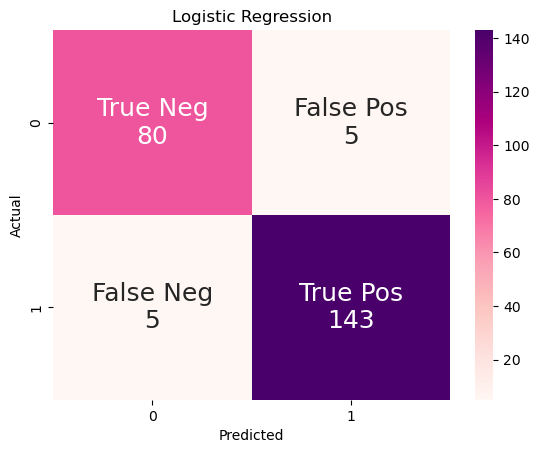

In [74]:
conf_lr = metrics.confusion_matrix(y_test, lr.predict(X_test_s))
conf_plot(conf_lr)
plt.title('Logistic Regression')
plt.savefig('conf_lr.png')

Confusion matrix of SVC:

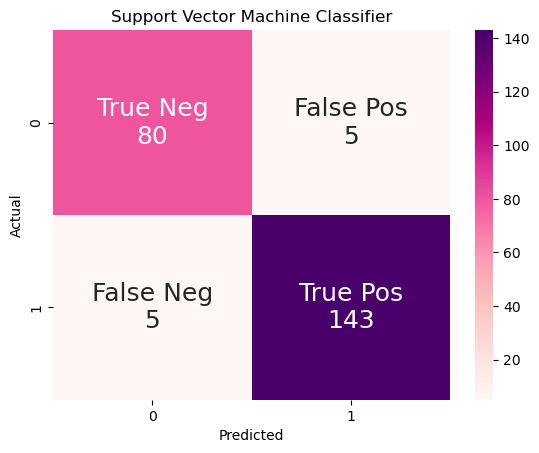

In [75]:
conf_svc = metrics.confusion_matrix(y_test, svc.predict(X_test_s))
conf_plot(conf_svc)
plt.title('Support Vector Machine Classifier')
plt.savefig('conf_svc.png')

Confusion matrix of NB:

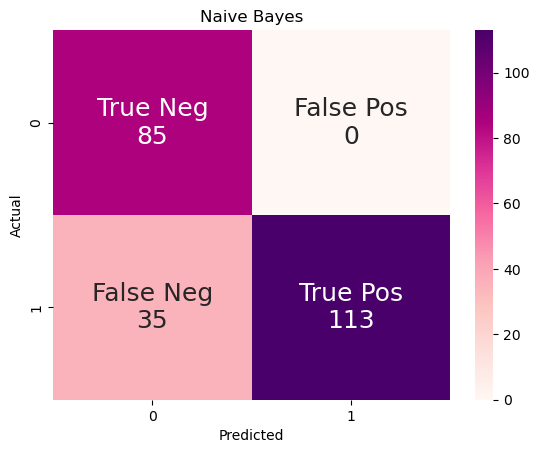

In [76]:
conf_nb = metrics.confusion_matrix(y_test, nb.predict(X_test_s))
conf_plot(conf_nb)
plt.title('Naive Bayes')
plt.savefig('conf_nb.png')

Confusion matrix of KNN:

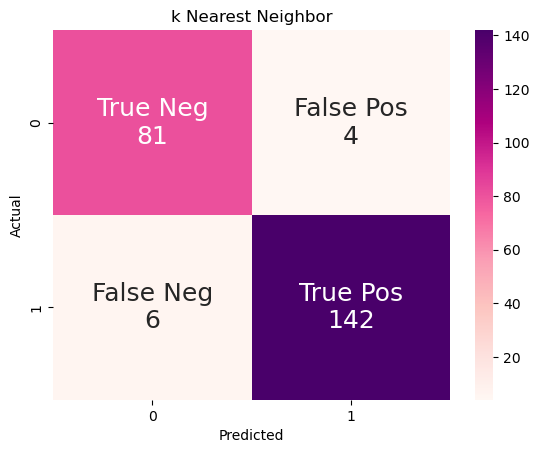

In [77]:
conf_knn = metrics.confusion_matrix(y_test, knn.predict(X_test_s))
conf_plot(conf_knn)
plt.title('k Nearest Neighbor')
plt.savefig('conf_knn.png')

Confusion matrix of DT:

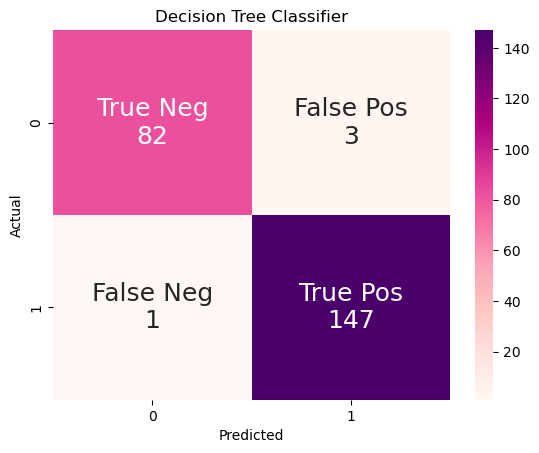

In [78]:
conf_dt = metrics.confusion_matrix(y_test, dt.predict(X_test_s))
conf_plot(conf_dt)
plt.title('Decision Tree Classifier')
plt.savefig('conf_dt.png')

NB has no false positive cases but this zero false positive is at the cost of a large amount of false negative. NB tends to be biased to negative. DT gives the least false negative, and the second best false positve rate as well. Overall, DT is the best model.

### 4.2 Model Evaluation Metrics

To evaluate the performance of differenct models, 6 performance metrics namely accuracy, precision, recall, specificity, F1 score and  AUC are calculated for each model.

- **Accuracy** = (True Positive + True Negative) / (True Positive + True Negative + False Positive + False Negative)
- **Precision** =  True Positive / (True Positive + False Positive)
- **Recall** = True Positive / (True Positive + False Negative)
- **Specificity** = True Negative / (True Negative + False Positive)
- **F1 Score** = Precision × Recall / (Precision + Recall)
- **AUC** = Area under the ROC Curve (receiver operating characteristic curve)

In [79]:
clfs = [lr, svc, nb, knn, dt]
clf_ls = ['LR', 'SVC', 'NB', 'KNN', 'DT']
pred_ls = np.array([clf.predict(X_test_s) for clf in clfs])
pred_df = pd.DataFrame(pred_ls.T)
pred_df.columns = clf_ls

In [80]:
score_df = pred_df.apply(lambda r: pd.Series({'Accuracy': metrics.accuracy_score(y_test, r), 
                                              'Precision': metrics.precision_score(y_test, r),
                                              'Recall': metrics.recall_score(y_test, r),
                                              'Specificity': metrics.recall_score(y_test, r, pos_label=0),
                                              'F1': metrics.f1_score(y_test,r)}))
score_df.index.name = 'Score'
auc_ls = [metrics.roc_auc_score(y_test, clf.predict_proba(X_test_s)[:,1]) for clf in clfs]
score_df.loc['AUC'] = auc_ls
score_df.round(4)

,LR,SVC,NB,KNN,DT
Score,,,,,
Accuracy,0.9571,0.9571,0.8498,0.9571,0.9828
Precision,0.9662,0.9662,1.0000,0.9726,0.9800
Recall,0.9662,0.9662,0.7635,0.9595,0.9932
Specificity,0.9412,0.9412,1.0000,0.9529,0.9647
F1,0.9662,0.9662,0.8659,0.9660,0.9866
AUC,0.9874,0.9888,0.9892,0.9914,0.9840


The performance scores confirm the ranking from the confusion matrice. NB gives zero false positive cases, resulting in a perfect 1 precision and specificity, however, it has the lowest accuracy, recall and F1 score because the false negative cases of NB is much higher than other models. DT has the best accuracy, precision and F1 score, and the second best precision and specificity. Although the DT's AUC is lower than other models, it is still the best model among the five when all metrics are taken into account. 

ROC curve and Precise-recall curve:

In [81]:
fpr_ls = []
tpr_ls = [] 
pres_ls = []
rec_ls = []
for clf in clfs:
    fpr, tpr, _ = metrics.roc_curve(y_test, clf.predict_proba(X_test_s)[:,1])
    pres, rec, _ = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test_s)[:,1])
    fpr_ls.append(fpr)
    tpr_ls.append(tpr)
    pres_ls.append(pres)
    rec_ls.append(rec)

In [82]:
clf_ls = ['LR', 'SVC', 'NB', 'KNN', 'DT']

roc_df = pd.DataFrame({'clf':clf_ls, 'fpr':fpr_ls, 'tpr':tpr_ls})
roc_df['auc'] = auc_ls

pres_rec_df = pd.DataFrame({'clf':clf_ls, 'pres':pres_ls, 'rec':rec_ls})
pres_rec_df['pr_auc'] = pres_rec_df.apply(lambda x: metrics.auc(x['rec'], x['pres']), axis = 1)

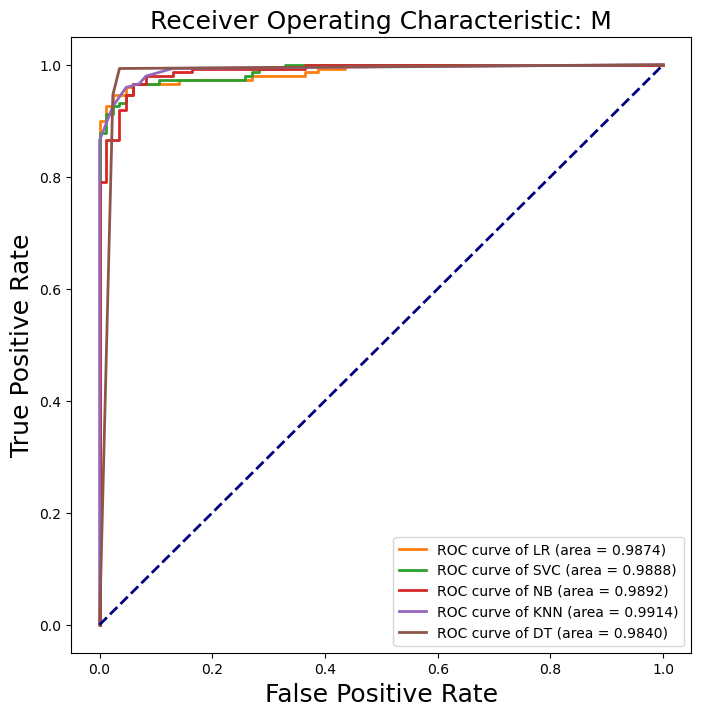

In [83]:
plt.figure(figsize=[8,8])
colors = ['C1','C2','C3','C4','C5']

for index, row in roc_df.iterrows():
    plt.plot(row['fpr'], row['tpr'], color=colors[index], lw = 2, label = 'ROC curve of {1} (area = {0:.4f})'.format(row['auc'], row['clf']))
    
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic: M', fontsize=18)
plt.legend(loc="lower right")

plt.savefig('roc.png')
plt.show()

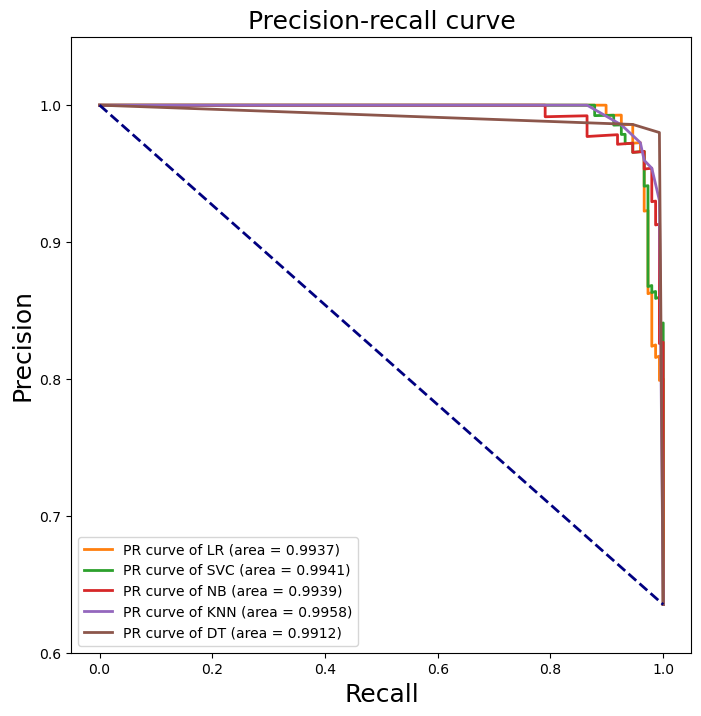

In [84]:
plt.figure(figsize=[8,8])

for index, row in pres_rec_df.iterrows():
    plt.plot(row['rec'], row['pres'], color=colors[index], lw = 2, label = 'PR curve of {1} (area = {0:.4f})'.format(row['pr_auc'],  row['clf']))

plt.plot([0, 1], [1, y_test.mean()], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([-0.05, 1.05])
plt.ylim([0.6, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-recall curve', fontsize=18)
plt.legend(loc="lower left")

plt.savefig('pres_rec.png')
plt.show()

The shape of the ROC curve and the Precision-Recall curve might explain why DT has the lowerst AUC: the curves for DT model have only 4 turning points. The number matches the 'max_depth' parameter.

### 4.3 Learning curves

In [85]:
LR, SVM, KNN, DT = (make_pipeline(StandardScaler(),clf) for clf in [lr, svc, knn, dt])

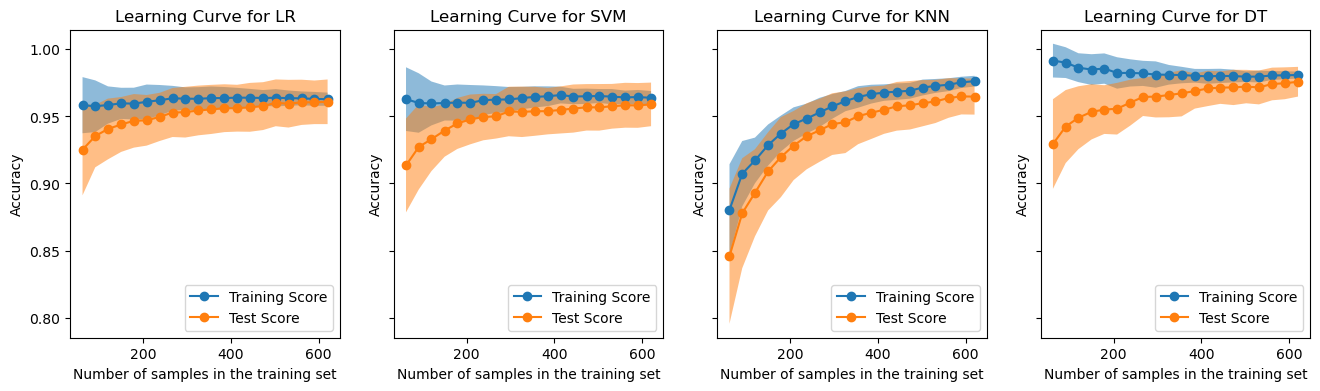

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)

common_params = {
    'X': X,
    'y': y,
    'train_sizes': np.linspace(0.1, 1.0, 20),
    'cv': ShuffleSplit(n_splits=50, test_size=0.2, random_state=42),
    'score_type': 'both',
    'n_jobs': -1,
    'line_kw': {'marker': 'o'},
    'std_display_style': 'fill_between',
    'score_name': 'Accuracy',
}

for ax_idx, estimator in enumerate([LR, SVM, KNN, DT]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ['Training Score', 'Test Score'], loc='lower right')
    ax[ax_idx].set_title(f"Learning Curve for {['LR','SVM','KNN','DT'][ax_idx]}")

plt.savefig('lc_clf.png')

The learning curves of different models (NB is excluded as it might be biased) also verifies that DT is the best classifier. DT gives best performance without overfitting.

### 4.5 Feature Importance with Decision Tree

In [87]:
importance = pd.DataFrame({'Features': X.columns, 'Importance': dt.feature_importances_}).sort_values('Importance', ascending = False)
importance.round(4)

,Features,Importance
0,para_a,0.6055
1,para_b,0.1885
5,district,0.1749
3,money,0.0311
2,numbers,0.0000
4,sector,0.0000
6,loss,0.0000
7,history,0.0000


Only four features: 'para_a', 'para_b', 'district' and 'money' have helped to improve the purity of all nodes.

Decision tree visualisation:

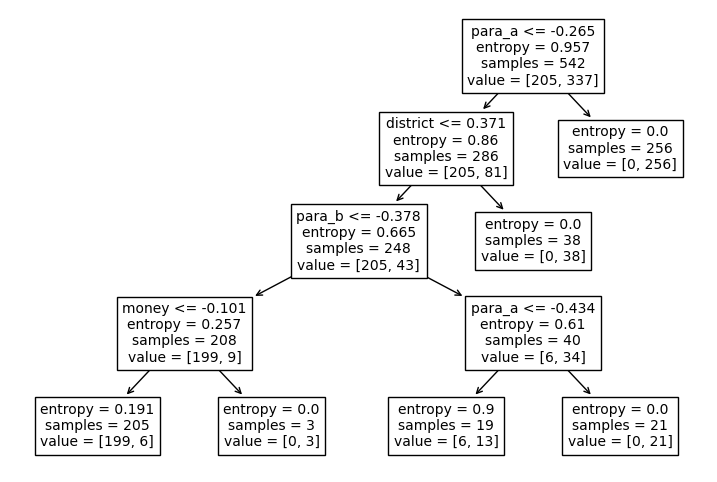

In [88]:
plt.figure(figsize=(9,6))
tree.plot_tree(dt, feature_names = X.columns, fontsize=10)
plt.savefig('tree.png')

## **5. Conclusion**

This analysis checks the applicability of machine learning models to predict the fraudulent companies during audit planning. A complete Audit Field Work Decision Support framework is proposed to help an auditor to decide the amount of field work required for a particular company and to skip visiting low risk firms, while high-risk companies are warrant for the maximum audit investigation.

Linear regression is performed to examine the relationship between risk factors and fraud risk score obtained from analytical procedure ('ars'). The model gives an R-squared of 0.8856 on the test set, indicating that 88.56% of the variation in 'ars' is explained by the predicting risk factors. This high R-squared is verified by 5-fold cross validation and the learning curve. Forward feature selection and Lasso regularisation show that all features contribute to the model, while these two selection methods give slightly different orders of feature importance.

Five classification models, Logistic Regression (LR), Support Vector machine classifier (SVC), Naive Bayesian (NB), k Nearest Neighbor (KNN) and Decision Tree (DT), are implemented to classify fraudulent companies. Model performance are evaluated under 6 metrics, namely accuracy, precision, recall, specificity, F1 score and AUC. NB gives zero false positive cases, which leads to a high precision and a high specificity, however, the false negative cases of NB is much higher than other models, leading to a low accuracy, recall and F1 score. Decision Tree (DT) has the best accuracy, precision and F1 score, and the second best precision and specificity. Although the DT's AUC is lower than other models, it is still the best model among the five when all metrics are taken into account. The feature importance with DT shows only four features have helped to improve the purity of all nodes.

Overall, both regression and classification machine learning models have both low bias and low variance, which are eligibileto perform an efficient risk assessment of the suspicious firms in the audit field work decision-making process.